In [20]:
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import arviz as az

In [4]:
df = pd.read_csv('per_game_data.csv').drop('Unnamed: 0', axis=1).head(1500)

X = df[['GS', 'MP', 'FG', 'FGA','2P', '2PA']]
y = df['PTS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- **Parameter Prior Distribution:**
  - $\theta \sim \mathcal{N}(\mu, \Sigma)$  
    This defines the prior distribution of the parameters $\theta$ as a multivariate normal distribution with mean vector $\mu$ and covariance matrix $\Sigma$.

- **Parameter Initialization Distribution:**
  - $\theta_0 \sim \mathcal{N}(0, I)$  
    This specifies the initial distribution of parameters $\theta_0$ as a multivariate normal distribution with a mean of zero and the identity matrix as the covariance (indicating independence and unit variance).

- **Optimization Objective:**
  - $\mu^*, \Sigma^* = \arg\min_{\mu,\Sigma} \sum_{(x_i, y_i) \in D_{tr}} \mathcal{L}(F_{\theta}(x_i), y_i) + KL[p(\theta) \| p(\theta_0)]$  
    This equation is the objective function for optimization. It is finding the optimal parameters $\mu^*$ and $\Sigma^*$ that minimize the sum of the loss function $\mathcal{L}$ over the training data $D_{tr}$, plus the Kullback-Leibler divergence between the current parameter distribution $p(\theta)$ and the initial parameter distribution $p(\theta_0)$.

- **Prediction:**
  - $p(y | \hat{x}, D_{tr}) = \int p(y | \hat{x}, \theta^*) p(\theta^* | D_{tr}) d\theta^*$  
    This equation describes the predictive distribution for a new input $\hat{x}$, integrating over all possible parameter values $\theta^*$, weighted by their posterior probability given the training data $D_{tr}$.

- **Posterior Parameter Distribution:**
  - $\theta^* \sim \mathcal{N}(\mu^*, \Sigma^*)$  
    This defines the posterior distribution of the parameters $\theta^*$ after training as a multivariate normal distribution with the optimized mean $\mu^*$ and covariance $\Sigma^*$.

- **Prediction Estimation:**
  - $\hat{y} = \frac{1}{K} \sum_{k=1}^{K} F_{\theta^*_k}(\hat{x})$  
    This is the final prediction for a new input $\hat{x}$, obtained by averaging the predictions from $K$ different parameter sets $\theta^*_k$, each drawn from the posterior distribution.

- **Individual Posterior Sample Distribution:**
  - $\theta^*_k \sim \mathcal{N}(\mu^*, \Sigma^*)$  
    Each $\theta^*_k$ is a sample from the posterior distribution of the parameters used for making individual predictions that are then averaged to compute $\hat{y}$.


In [66]:
def construct_nn(ann_input, ann_output):
    n_hidden = 32

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden)
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_out = np.random.randn(n_hidden)

    with pm.Model() as BayesianNN:

        ann_input = pm.Data('ann_input', X_train, mutable=True)
        ann_output = pm.Data('ann_output', y_train, mutable=True)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 initval=init_1)
        
        # Bias for first hidden layer
        bias_1 = pm.Normal('b_1', 0, sigma=1, shape=(n_hidden,), initval=np.zeros(n_hidden))


        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                initval=init_2)
        
        # Bias for second hidden layer
        bias_2 = pm.Normal('b_2', 0, sigma=1, shape=(n_hidden,), initval=np.zeros(n_hidden))

        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  initval=init_out)
        # Bias for output layer
        bias_out = pm.Normal('b_out', 0, sigma=1, shape=(1,), initval=np.zeros(1))

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1) + bias_1)
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2) + bias_2)
        act_out = pm.math.dot(act_2, weights_2_out) + bias_out

        sigma = pm.HalfCauchy('sigma', beta=10, initval=1)
        out = pm.Normal('out', mu=act_out, sigma=sigma, total_size=y_train.shape[0], observed=ann_output, shape=act_out.shape)

    return BayesianNN


bnn = construct_nn(X_train_scaled, y_train)

Finished [100%]: Average Loss = 88,163


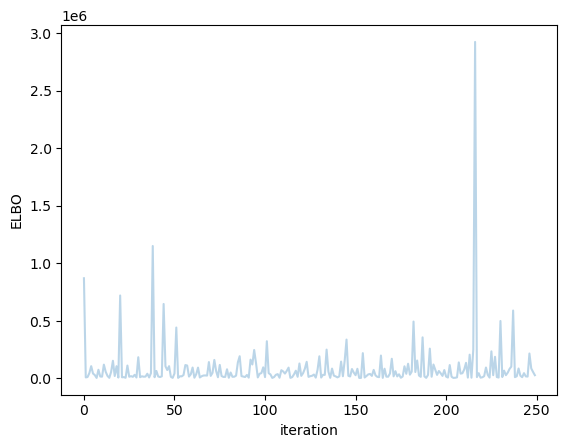

In [34]:
with bnn:
    approx = pm.fit(n=10000, method='advi')

plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [51]:
trace = approx.sample(draws=3000)

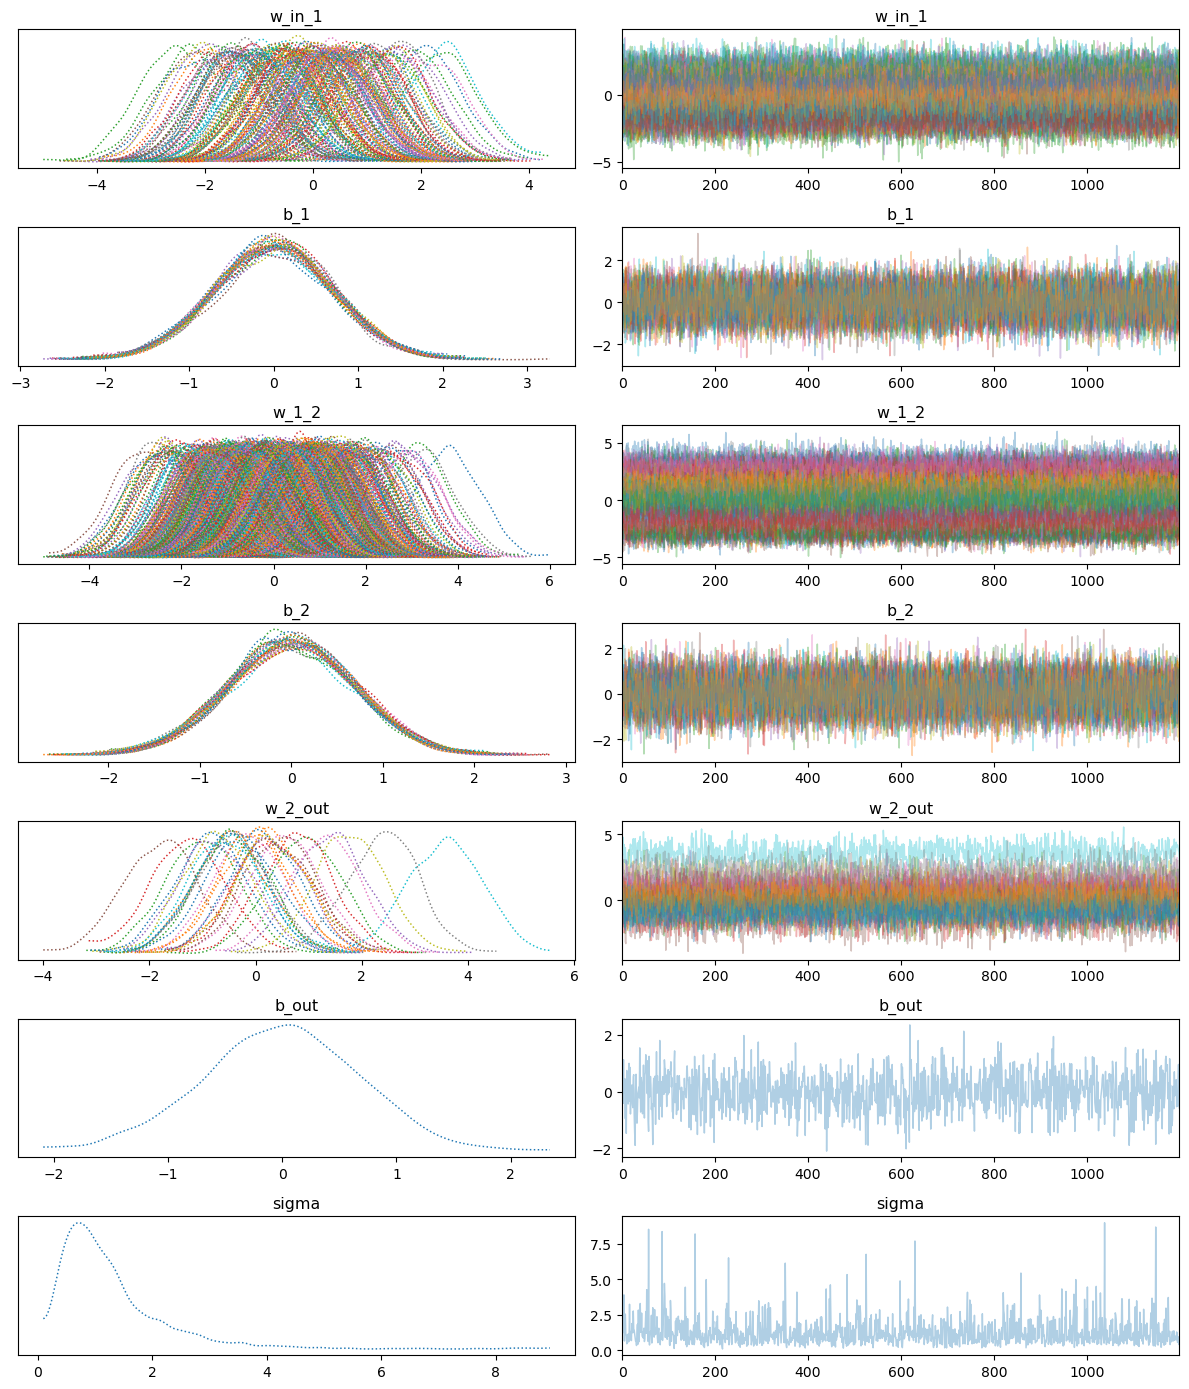

In [36]:
az.plot_trace(trace, combined=True)
plt.tight_layout()

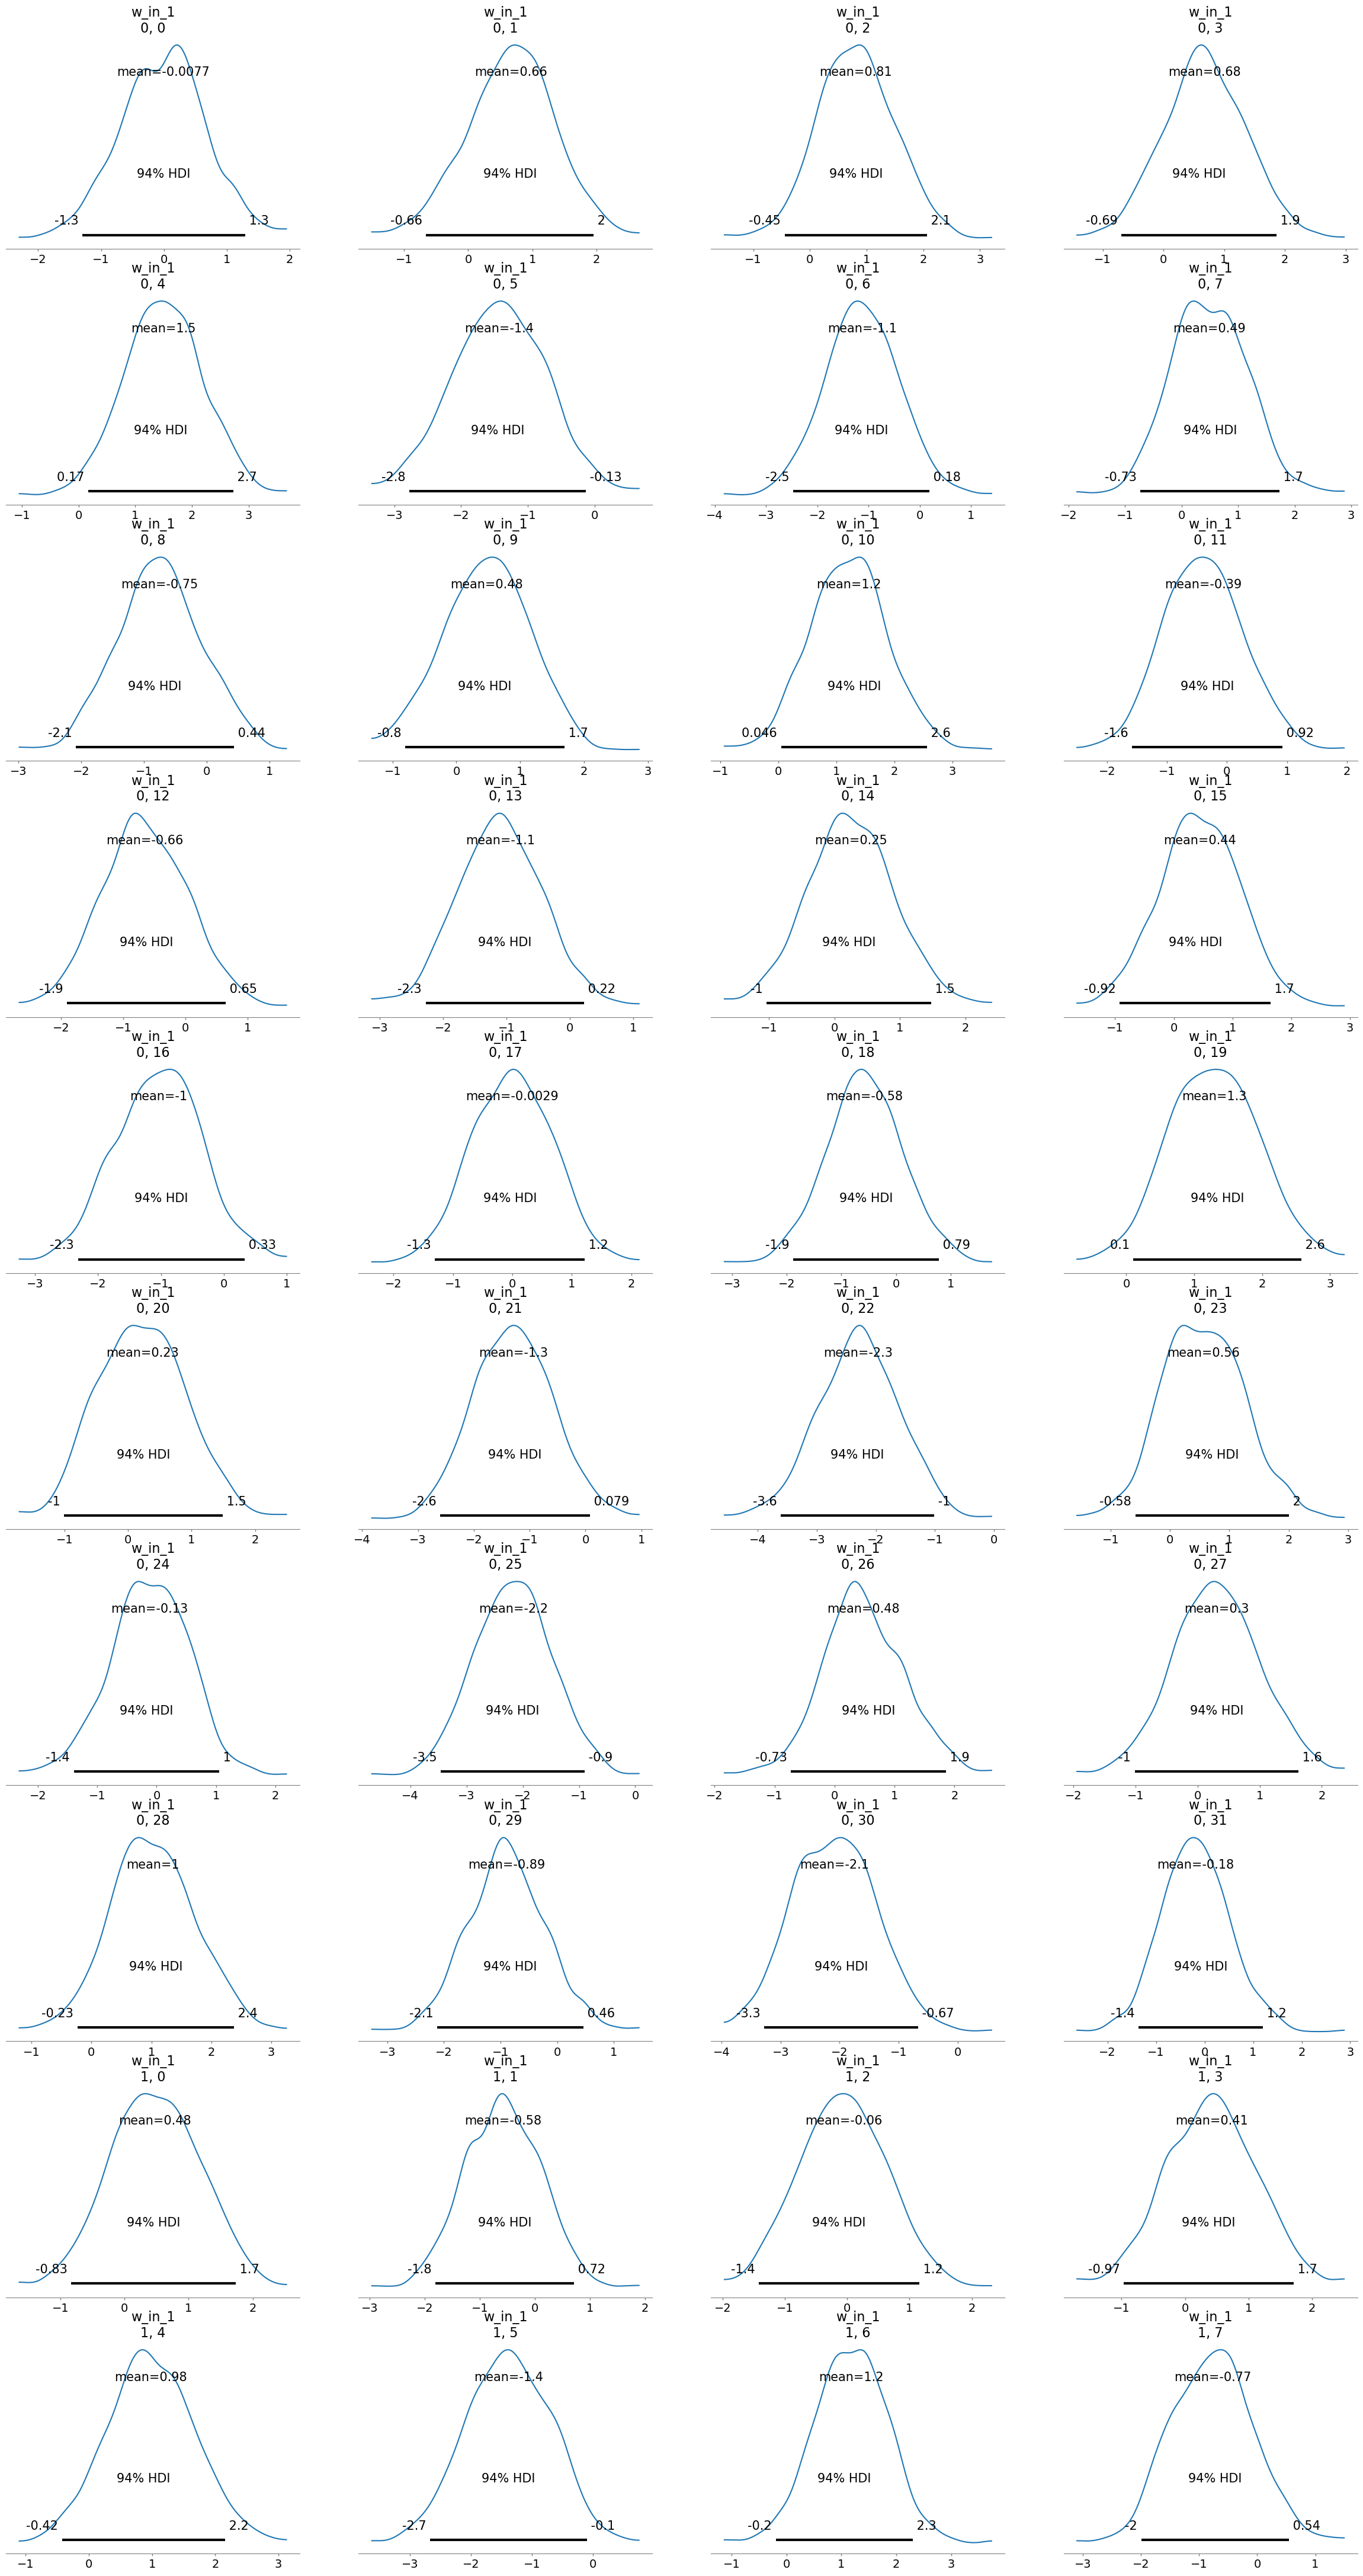

In [38]:
az.plot_posterior(trace);

In [56]:
with bnn:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [68]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw"))
pred
# plt.plot(y_test.values, label='True')
# plt.plot(pred, label = 'Predictions')
# plt.legend()

<xarray.DataArray 'out' (out_dim_2: 300)> Size: 2kB
array([4.78180235, 4.89194049, 4.70017531, 4.8992591 , 5.79110135,
       5.33625834, 4.84716441, 5.25825865, 5.20274302, 5.07408208,
       5.41038358, 3.916977  , 5.29590208, 3.96633525, 5.36387689,
       4.78348413, 5.60547773, 4.94333753, 4.9604951 , 5.45804171,
       4.85347374, 4.88643617, 5.76518893, 4.90562038, 4.88966615,
       4.9286505 , 5.18196405, 4.93522542, 4.74226968, 5.58230916,
       4.70802987, 3.8314923 , 4.70358322, 4.78255025, 3.68031174,
       5.54551456, 5.27057134, 4.83063928, 4.88203727, 3.64600851,
       5.19086727, 5.05055103, 4.79599861, 4.90247361, 5.8372392 ,
       5.54595978, 4.90377199, 5.48185779, 5.31786108, 5.36978597,
       4.90786551, 5.01789942, 5.34511088, 3.9420181 , 3.851306  ,
       4.97659185, 4.86345872, 5.09915273, 5.80663041, 5.27109096,
       4.81015442, 5.05354637, 4.69213958, 5.4631368 , 4.99065093,
       5.31175214, 4.80395407, 4.24083345, 5.62400769, 5.59761006,
       5.18593748, 5.19325275, 5.14846718, 5.07466974, 4.8511228 ,
       4.95049951, 4.73989635, 5.40823587, 4.9898142 , 4.88309313,
       5.46231832, 3.67573456, 5.80435525, 5.24060192, 5.06632102,
       4.90822559, 5.06068304, 4.9455622 , 4.82093825, 5.24783715,
       4.91716726, 5.6590968 , 5.65192977, 4.92037945, 5.76098795,
       5.26606518, 5.1924941 , 4.77342568, 4.70098838, 5.12149551,
...
       4.8704832 , 5.34055491, 5.7602269 , 4.01930541, 4.94503869,
       4.81664578, 5.55334291, 4.56847314, 5.16901162, 4.87477399,
       4.44625808, 4.89460701, 5.24352246, 4.89423969, 5.17510918,
       4.93296194, 5.73432354, 4.8702587 , 4.9327237 , 5.3700549 ,
       5.20545571, 4.83280012, 5.12089522, 4.73217393, 4.92392279,
       5.27326138, 3.65813659, 5.55472534, 5.289355  , 4.86489429,
       4.97356438, 4.82683805, 5.29142674, 4.85124721, 4.87304796,
       5.75338651, 5.01326074, 4.86422097, 3.92995264, 4.98290205,
       5.42182808, 5.18544422, 4.8375257 , 5.47743971, 5.0346811 ,
       4.72266677, 4.95247531, 4.82039966, 5.74604376, 5.0326859 ,
       4.7180594 , 5.80425473, 4.75693673, 4.69808207, 5.31708913,
       5.3885001 , 4.9882351 , 5.10744863, 5.09730256, 5.22222457,
       5.41402781, 3.65392546, 3.79794521, 5.04542901, 4.95426144,
       4.95734643, 4.60552565, 5.55598388, 4.83022692, 5.38621188,
       4.8767192 , 4.90700133, 5.30294041, 4.9210398 , 5.23124793,
       4.99346016, 4.96059707, 4.77457257, 5.66667988, 5.18152449,
       4.68023092, 4.8391063 , 4.92433225, 5.40730581, 5.18467361,
       4.56385698, 5.17023867, 4.42147583, 4.91612321, 4.76395184,
       4.92016548, 4.87598618, 4.47208964, 4.46221364, 5.19180254,
       4.80037471, 4.99313876, 5.13818318, 5.77891302, 5.46910754])
Coordinates:
  * out_dim_2  (out_dim_2) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299

In [ ]:
### New Data
X_new_scaled = scaler.transform(X_new)


#### Tensorflow Version (might not use)

In [3]:
import tensorflow as tf
import tf_keras
import tensorflow_probability as tfp
import seaborn as sns
tfd = tfp.distributions

In [54]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [57]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf_keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf_keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])




In [60]:
# Build model.
model = tf_keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=True);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

Epoch 1/1000
5/5 [==============================] - 1s 1ms/step - loss: 140.5006
Epoch 2/1000
5/5 [==============================] - 0s 1ms/step - loss: 824.5915
Epoch 3/1000
5/5 [==============================] - 0s 2ms/step - loss: 752.3864
Epoch 4/1000
5/5 [==============================] - 0s 2ms/step - loss: 959.8691
Epoch 5/1000
5/5 [==============================] - 0s 2ms/step - loss: 187.4374
Epoch 6/1000
5/5 [==============================] - 0s 1ms/step - loss: 429.3801
Epoch 7/1000
5/5 [==============================] - 0s 745us/step - loss: 501.2984
Epoch 8/1000
5/5 [==============================] - 0s 1ms/step - loss: 346.0407
Epoch 9/1000
5/5 [==============================] - 0s 2ms/step - loss: 471.4918
Epoch 10/1000
5/5 [==============================] - 0s 1ms/step - loss: 863.0135
Epoch 11/1000
5/5 [==============================] - 0s 1ms/step - loss: 213.4774
Epoch 12/1000
5/5 [==============================] - 0s 2ms/step - loss: 124.0707
Epoch 13/1000
5/5 [====